Theory Questions:

• Q1: Why is the KL Divergence term important in the VAE loss function?
It makes the latent space smooth, continuous, and usable for generating new data.

• Q2: How does the reparameterization trick enable backpropagation through the stochastic layers of a VAE?
The reparameterization trick lets a VAE backpropagate through random sampling by rewriting it as a differentiable function of the encoder's outputs and independent noise.

• Q3: Why does a VAE use a probabilistic latent space instead of a fixed latent space?
A VAE uses a probabilistic latent space so it can learn a smooth, continuous distribution of data that supports uncertainty and allows meaningful generation of new samples, rather than just storing fixed compressed codes like a regular autoencoder.

• Q4: What role does KL Divergence play in ensuring a smooth latent space?

KL Divergence encourages the learned latent distributions to match a standard normal prior, which prevents gaps and irregular clusters in the latent space and makes it smooth and continuous for interpolation and sampling.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [30]:
# VAE Architecture (Conv-only)
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder: (B,1,28,28) -> (B,hidden_dim,14,14)
        self.enc = nn.Conv2d(1, hidden_dim, 3, stride=2, padding=1)

        # Latent maps: (B,hidden_dim,14,14) -> (B,latent_dim,14,14)
        self.mu = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)
        self.logvar = nn.Conv2d(hidden_dim, latent_dim, 3, padding=1)

        # Decoder: (B,latent_dim,14,14) -> (B,hidden_dim,14,14) -> (B,1,28,28)
        self.dec = nn.Conv2d(latent_dim, hidden_dim, 3, padding=1)
        self.up  = nn.ConvTranspose2d(hidden_dim, 1, 4, stride=2, padding=1)

    def encode(self, x):
        h = torch.relu(self.enc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.dec(z))
        return torch.sigmoid(self.up(h))

    def forward(self, x):
        # x is already (B,1,28,28) from MNIST transforms.ToTensor()
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [31]:
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [32]:
# Training the VAE
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

In [35]:
# Load MNIST dataset and run the training
transform = transforms.ToTensor()
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)

vae = VAE(input_dim=784, hidden_dim=64, latent_dim=8)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(1, 11):
    train(vae, train_loader, optimizer, epoch)


Epoch 1, Loss: 205.56220553385415
Epoch 2, Loss: 160.77029039713543
Epoch 3, Loss: 153.87720439453125
Epoch 4, Loss: 151.0228604654948
Epoch 5, Loss: 149.54085677083333
Epoch 6, Loss: 148.45496495768228
Epoch 7, Loss: 147.71820096028645
Epoch 8, Loss: 147.2289237955729
Epoch 9, Loss: 146.76122233072917
Epoch 10, Loss: 146.40755768229167


In [46]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def generate_images(model, num_images=5, latent_dim=20, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # Sample latent FEATURE MAP (not a vector)
    z = torch.randn(num_images, latent_dim, 14, 14).to(device)

    # Decode to images
    imgs = model.decode(z).cpu()   # (B,1,28,28)

    # Plot
    fig, axs = plt.subplots(1, num_images, figsize=(num_images * 1.5, 1.8))
    for i in range(num_images):
        axs[i].imshow(imgs[i, 0], cmap="gray")
        axs[i].axis("off")
    plt.show()


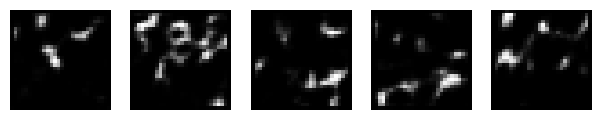

In [48]:
generate_images(vae, num_images=5, latent_dim=8)


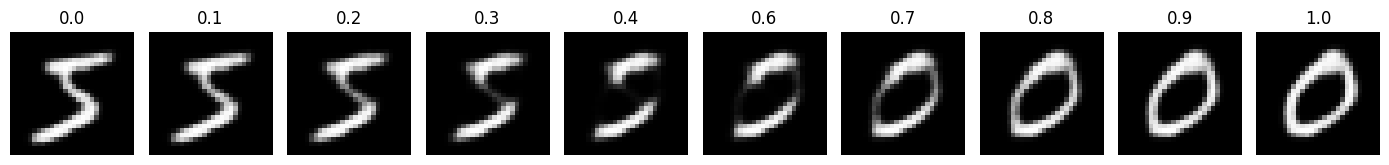

In [49]:
import torch
import matplotlib.pyplot as plt

@torch.no_grad()
def interpolate_latent(model, dataset, idx1=0, idx2=1, steps=10, device=None):
    model.eval()
    if device is None:
        device = next(model.parameters()).device

    # 1) Get two images
    x1, _ = dataset[idx1]
    x2, _ = dataset[idx2]
    x1 = x1.unsqueeze(0).to(device)   # (1,1,28,28)
    x2 = x2.unsqueeze(0).to(device)

    # 2) Encode to latent (use mu for smooth interpolation)
    mu1, _ = model.encode(x1)         # (1, latent_dim, 14, 14)
    mu2, _ = model.encode(x2)

    # 3) Interpolate
    alphas = torch.linspace(0, 1, steps).to(device)
    zs = [(1 - a) * mu1 + a * mu2 for a in alphas]

    # 4) Decode
    imgs = [model.decode(z).cpu()[0, 0] for z in zs]  # each is (28,28)

    # 5) Plot in a row grid
    fig, axs = plt.subplots(1, steps, figsize=(steps * 1.4, 1.8))
    for i in range(steps):
        axs[i].imshow(imgs[i], cmap="gray")
        axs[i].axis("off")
        axs[i].set_title(f"{i/(steps-1):.1f}")
    plt.tight_layout()
    plt.show()

# Example usage:
# interpolate between two dataset images (change indices to try different digits)
interpolate_latent(vae, train_dataset, idx1=0, idx2=1, steps=10)


Epoch 1 loss 1938.1316375732422
Epoch 2 loss 1853.8431396484375
Epoch 3 loss 1841.2910412597657


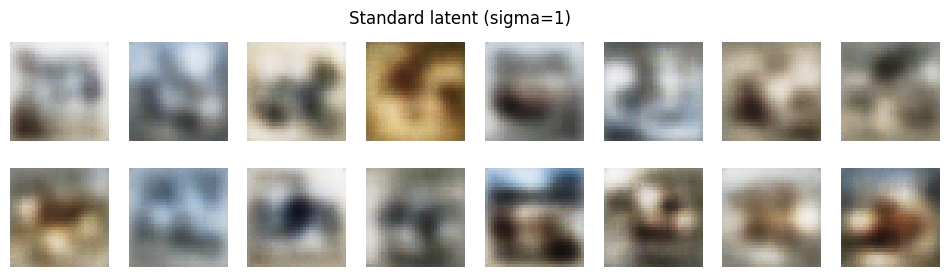

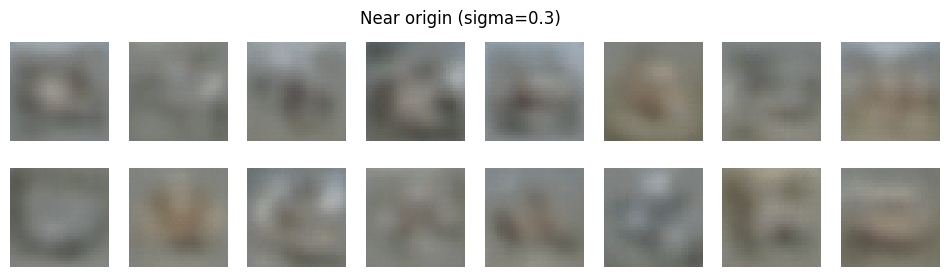

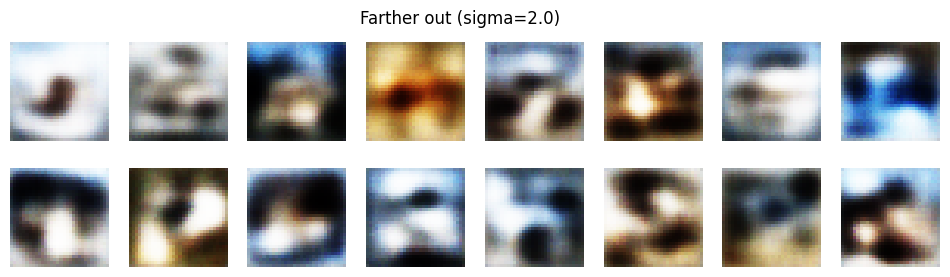

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

transform = transforms.ToTensor()
train_data = datasets.CIFAR10("./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

class VAE(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder: (B,3,32,32) -> (B,64,8,8)
        self.enc = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),   # 32->16
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),  # 16->8
        )
        self.flat = 64 * 8 * 8
        self.mu = nn.Linear(self.flat, latent_dim)
        self.logvar = nn.Linear(self.flat, latent_dim)

        # Decoder: latent -> (B,64,8,8) -> (B,3,32,32)
        self.fc = nn.Linear(latent_dim, self.flat)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),  # 8->16
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid() # 16->32
        )

    def forward(self, x):
        h = self.enc(x).view(x.size(0), -1)
        mu, logvar = self.mu(h), self.logvar(h)
        z = mu + torch.randn_like(mu) * torch.exp(0.5 * logvar)
        recon = self.dec(self.fc(z).view(x.size(0), 64, 8, 8))
        return recon, mu, logvar

def loss_fn(recon, x, mu, logvar):
    bce = F.binary_cross_entropy(recon, x, reduction="sum")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kld

vae = VAE(latent_dim=32)
opt = optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(3):
    vae.train()
    total = 0
    for i, (x, _) in enumerate(train_loader):
        if i == 200:  # stop early for speed
            break
        opt.zero_grad()
        recon, mu, logvar = vae(x)
        loss = loss_fn(recon, x, mu, logvar)
        loss.backward()
        opt.step()
        total += loss.item()
    print("Epoch", epoch+1, "loss", total/(200*128))


@torch.no_grad()
def show(z, title):
    vae.eval()
    imgs = vae.dec(vae.fc(z).view(z.size(0), 64, 8, 8))
    fig, axs = plt.subplots(2, 8, figsize=(12, 3))
    fig.suptitle(title)
    for i in range(16):
        ax = axs[i//8, i%8]
        ax.imshow(imgs[i].permute(1,2,0))
        ax.axis("off")
    plt.show()

# Standard region (N(0,1))
z1 = torch.randn(16, vae.latent_dim)
show(z1, "Standard latent (sigma=1)")

# Near origin (small noise)
z2 = 0.3 * torch.randn(16, vae.latent_dim)
show(z2, "Near origin (sigma=0.3)")

# Farther out (large noise)
z3 = 2.0 * torch.randn(16, vae.latent_dim)
show(z3, "Farther out (sigma=2.0)")
